# Tmax Subset

A notebook to subset Tmax daily for the 13000 GHS urban areas to identify dates >40c, consecuritve days >40 c etc.

### Depdencies

In [1]:
import pandas as pd
import numpy as np
import xarray as xr
from random import random
from itertools import groupby
from operator import itemgetter
import geopandas as gpd 
import glob

In [2]:
def csv_to_xr(file_in, time_dim, space_dim):
    
    """ Function reads in a csv w/ GHS-UCDB IDs and temp, isolates the temp
    and returns a xarray data array with dims set to city ids and dates
    
    Args:
        file_in = file name and path
        time_dim = name for time dim as a str ... use date :-)
        space_dim = col name for GHS-UCDB IDs as an str (ID_HDC_G0)
    """
    
    df = pd.read_csv(file_in) # read the file in as a df
    print(df.shape)
    
    df_id = df[space_dim] # get IDs
    df_temp = df.iloc[:,3:] # get only temp columns
    df_temp.index = df_id # set index values
    df_temp_drop = df_temp.dropna() # Drop cities w/ no temp record 
    print(len(df_temp_drop))
    
    temp_np = df_temp_drop.to_numpy() # turn temp cols into an np array
    
    # make xr Data Array w/ data as temp and dims as spece (e.g. id)
    temp_xr_da = xr.DataArray(temp_np, coords=[df_temp_drop.index, df_temp_drop.columns], dims=[space_dim, time_dim])
    
    return temp_xr_da

In [3]:
def temp_eventTot(xarray, Tthresh, year):
    """ Function returns the number of days within a year where Tmax > Tthresh for each city.
    
    Args: 
        xarray = an xarray object with dims = (space, times)
        Tthresh = int of temp threshold
    """
    
    ## NOTE FOR SOME REASON out.ID_HDC_G0 cannot be fed a string ... note sure why so be careful with col names
    out = xarray.where(xarray > Tthresh, drop = True)
    id_list = []
    event_tot = []
    df_out = pd.DataFrame()
    
    for index, loc in enumerate(out.ID_HDC_G0):
        id_list.append(out.ID_HDC_G0.values[index])
        event_tot.append(len(out.sel(ID_HDC_G0 = loc).dropna(dim = 'date').date.values))
    
    df_out['ID_HDC_G0'] = id_list
    df_out[year] = event_tot
    
    return df_out

In [4]:
def event_loop(dir_nm, time_dim, space_dim, Tthresh):
    
    """ Loop through a dir with csvs to calc the total number of events greater than a threshold.
        Leap years explain the difference in shapes 368 vs 369
    
    Args:
        dir_nm = dir path to loop through
        time_dim = name for time dim as a str ... use date :-) for csv_to_xr function
        space_dim = col name for GHS-UCDB IDs as an str (ID_HDC_G0) for csv_to_xr function
        Tthresh = int of temp threshold for temp_event function -- 40.6 is
    """
    
    # Open the GHS-ID List with GeoPANDAS read_file
    ghs_ids_fn = 'GHS-UCSB-IDS.csv'
    ghs_ids_df = pd.read_csv(DATA_INTERIM+ghs_ids_fn)
    
    # Git File list
    fn_list = glob.glob(DAILY_PATH+'*.csv')
    
    for fn in sorted(fn_list):
        
        # Get year for arg for temp_event function
        year = fn.split('GHS-Tmax-DAILY_')[1].split('.csv')[0]
        print(year)
        
        temp_xr_da = csv_to_xr(fn, time_dim, space_dim)
        
        df_out = temp_eventTot(temp_xr_da, Tthresh, year)
        
        ghs_ids_df = ghs_ids_df.merge(df_out, on='ID_HDC_G0', how = 'outer') #<<<<----- NEED TO FIX THIS
    
    # build in later drop all NA GHS-IDs
    
    return ghs_ids_df


In [43]:
# File Paths
DAILY_PATH = '/home/cascade/projects/data_out/CHIRTS-GHS-DAILY/'
DATA_INTERIM = '/home/cascade/projects/UrbanHeat/data/interim/'
DATA_OUT = '/home/cascade/projects/data_out/'

In [6]:
all_events_df = event_loop(DAILY_PATH, 'date', 'ID_HDC_G0', 40.6)

1983
(13135, 368)
13067
1984
(13135, 369)
13067
1985
(13135, 368)
13067
1986
(13135, 368)
13067
1987
(13135, 368)
13067
1988
(13135, 369)
13067
1989
(13135, 368)
13067
1990
(13135, 368)
13067
1991
(13135, 368)
13067
1992
(13135, 369)
13067
1993
(13135, 368)
13067
1994
(13135, 368)
13067
1995
(13135, 368)
13067
1996
(13135, 369)
13067
1997
(13135, 368)
13067
1998
(13135, 368)
13067
1999
(13135, 368)
13067
2000
(13135, 369)
13067
2001
(13135, 368)
13067
2002
(13135, 368)
13067
2003
(13135, 368)
13067
2004
(13135, 369)
13067
2005
(13135, 368)
13067
2006
(13135, 368)
13067
2007
(13135, 368)
13067
2008
(13135, 369)
13067
2009
(13135, 368)
13067
2010
(13135, 368)
13067
2011
(13135, 368)
13067
2012
(13135, 369)
13067
2013
(13135, 368)
13067
2014
(13135, 368)
13067
2015
(13135, 368)
13067
2016
(13135, 369)
13067


In [34]:
all_events_df.head()

,ID_HDC_G0,CTR_MN_NM,1983,1984,1985,1986,1987,1988,1989,1990,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,5782,Russia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3316,Russia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5645,Russia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3185,Finland,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3539,Russia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
# Move IDS to Index 

all_events_df = all_events_df.set_index(['ID_HDC_G0', 'CTR_MN_NM'], drop = True)
all_events_df.head()

,,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
ID_HDC_G0,CTR_MN_NM,,,,,,,,,,,,,,,,,,,,,
5782,Russia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3316,Russia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5645,Russia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3185,Finland,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3539,Russia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
# Drop NaNs
all_events_df_drop = all_events_df.dropna(how = 'all')
all_events_df_drop.shape

(7028, 34)

In [44]:
#all_events_df_drop.to_csv(DATA_OUT+'20190831_TMax-GHS_TotEvents83-2016.csv')

### Plot it

Text(0.5, 1.0, 'For all cities with Tmax >40, how many days in 1983 were >40C?')

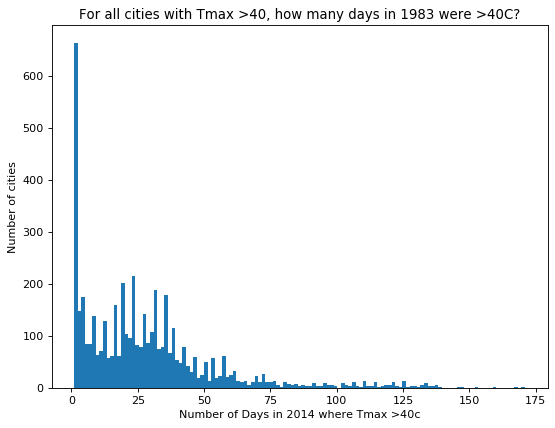

In [50]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure
%matplotlib inline

figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
y = range(1,125)
plt.hist(all_events_df_drop['2014'], bins = 125)
plt.xlabel('Number of Days in 2014 where Tmax >40c')
plt.ylabel('Number of cities')
plt.title('For all cities with Tmax >40, how many days in 1983 were >40C?')

Text(0.5, 1.0, 'For all cities with Tmax >40, how many days in 1990 were >40C?')

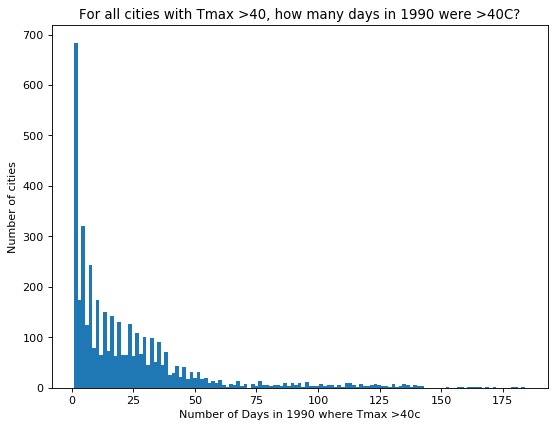

In [55]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure
%matplotlib inline

figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
y = range(1,125)
year = '1990'
plt.hist(all_events_df_drop[year], bins = 125)
plt.xlabel('Number of Days in '+year+' where Tmax >40c')
plt.ylabel('Number of cities')
plt.title('For all cities with Tmax >40, how many days in '+year+' were >40C?')

In [ ]:
# MAP BACK TO POLYGONS AND LOOK AT IT 
SHP_DIR = '/Users/cascade/Github/UrbanHeat/data/raw/ghs-ucdb/'
shp_fn = 'GHS_STAT_UCDB2015MT_GLOBE_R2019A_V1_0.shp'
shps = gpd.read_file(SHP_DIR+shp_fn)

In [ ]:
df_ghs = gpd.GeoDataFrame()
df_ghs['geometry'] = shps.geometry
df_ghs['ID_HDC_G0'] = shps.ID_HDC_G0

In [ ]:
df_merge = df_ghs.merge(events, on='ID_HDC_G0', how = 'inner') #<<<<----- NEED TO FIX THIS

In [ ]:
# Write it out
DATA_INTERIM = '/Users/cascade/Github/UrbanHeat/data/interim/'
fn_out = 'GHS-TmaxDaily-events.shp'
df_merge.to_file(DATA_INTERIM+fn_out)

# Old Code

In [ ]:
# This will return the ID and Date where Tmax is greater than 40 as a dict, but will not return actual tempatures 

Tmax = np.random.randint(20, high=50, size=(3,10)) # Make a 3x10 random list
print(Tmax)
results = np.where(Tmax > 40) # find the index and rows
coords = list(zip(results[0], results[1])) # zip the i and js into tuples

b = [(k, list(list(zip(*g))[1])) for k, g in groupby(coords, itemgetter(0))] # group by rows

print(b)
dict_out = dict(b) # turn into a dict, where keys are city ids and values are dates
dict_out


In [ ]:
for key, value in dict_out.items():
    print(key, value)

In [ ]:
np.where(Tmax > 40, Tmax, Tmax*0) 

In [ ]:
np.where(Tmax > 40) 

In [ ]:
np.argwhere(Tmax>1)

In [ ]:
def temp_search(array):
    results = np.where(array > 40) # find the index and rows
    coords = list(zip(results[0], results[1])) # zip the i and js into tuples
    b = [(k, list(list(zip(*g))[1])) for k, g in groupby(coords, itemgetter(0))] # group by rows
    dict_out = dict(b) # turn into a dict, where keys are city ids and values are dates

    return dict_out

In [ ]:
file_in = '/Users/cascade/Desktop/GHS-Tmax-DAILY_1983.csv'

df = pd.read_csv(file_in)

In [ ]:
df.head()

In [ ]:
df_sub = df.iloc[:,3:]

In [ ]:
df_sub_drop = df.dropna(how='all')

In [ ]:
df_sub.head()
arr = df_sub.to_numpy()

In [ ]:
arr.shape

In [ ]:
np.unique(arr)

In [ ]:
tmax_search = temp_search(arr)

In [ ]:
# Make some fake data
Tmax = np.random.randint(20, high=50, size=(3,10))
locs = ['001', '002', '003']
times = pd.date_range('2000-01-01', periods=10)

In [ ]:
foo = xr.DataArray(Tmax, coords=[locs, times], dims=['space', 'times'])

In [ ]:
foo

In [ ]:
out = foo.where(foo > 40, drop = True)
out

In [ ]:
for loc in out.space:
    print(len(out.sel(space = loc).dropna(dim = 'times').times.values))

In [ ]:
for x in out.space.values:
    print(x)

In [ ]:
out.space.values[0]